In [1]:
#default_exp core

In [2]:
# export
import math
import os
import random
import uuid
from typing import Any

import albumentations as A
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from timm.data.auto_augment import *
from timm.data.constants import DEFAULT_CROP_PCT, IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data.random_erasing import RandomErasing
from timm.data.transforms import RandomResizedCropAndInterpolation, _pil_interp
from torchvision import transforms
from torchvision.datasets.folder import pil_loader

# export
CASSAVA_MEAN = (0.42984136, 0.49624753, 0.3129598)
CASSAVA_STD = (0.21417203, 0.21910103, 0.19542212)

In [3]:
import matplotlib.pyplot as plt

In [4]:
pd.set_option("display.max_colwidth", None)

In [5]:
# export
idx2lbl = {
    0: "Cassava Bacterial Blight (CBB)",
    1: "Cassava Brown Streak Disease (CBSD)",
    2: "Cassava Green Mottle (CGM)",
    3: "Cassava Mosaic Disease (CMD)",
    4: "Healthy",
}


conf_mat_idx2lbl = {
    0: "CBB",
    1: "CBSD",
    2: "CGM",
    3: "CMD",
    4: "Healthy",
}

In [6]:
# export
def seed_everything(seed: int) -> int:
    """sets a seed for the environment in :
       `pytorch`, `numpy`, `python.random` and sets `PYTHONHASHSEED` environment variable.
    """
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # pytorch-seeds
    torch.manual_seed(seed)

    # cuda seeds
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    return seed


# export
def generate_random_id() -> str:
    "generates a random id"
    idx = uuid.uuid1()
    idx = str(idx).split("-")[0]
    return idx

In [7]:
# export
def load_dataset(
    pth: str, im_dir: str, curr_fold: int = 0, shuffle: bool = True
) -> pd.DataFrame:
    "loads the dataframe and formats it"
    assert curr_fold < 5

    data = pd.read_csv(pth)

    data["filePath"] = [
        os.path.join(im_dir, data["image_id"][idx]) for idx in range(len(data))
    ]
    data["is_valid"] = [data.kfold[n] == curr_fold for n in range(len(data))]
    data["label"].replace(idx2lbl, inplace=True)

    if shuffle:
        data = data.sample(frac=1).reset_index(drop=True, inplace=False)
    else:
        data = data.reset_index(drop=True, inplace=False)

    return data

In [8]:
csv_path = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
imgs_dir = "../../Datasets/cassava/train_images/"

df = load_dataset(csv_path, imgs_dir, curr_fold=0, shuffle=True)
df.head()

,image_id,label,filePath,kfold,is_valid
0,748345018.jpg,Cassava Mosaic Disease (CMD),../../Datasets/cassava/train_images/748345018.jpg,3,False
1,490760030.jpg,Cassava Brown Streak Disease (CBSD),../../Datasets/cassava/train_images/490760030.jpg,1,False
2,960202242.jpg,Cassava Green Mottle (CGM),../../Datasets/cassava/train_images/960202242.jpg,0,True
3,366838317.jpg,Cassava Bacterial Blight (CBB),../../Datasets/cassava/train_images/366838317.jpg,4,False
4,1345657742.jpg,Cassava Green Mottle (CGM),../../Datasets/cassava/train_images/1345657742.jpg,4,False


In [9]:
# export
class ImageClassificationFromDf(torch.utils.data.Dataset):
    """
    Image classification dataset.
    Args:
        dataframe: dataframe with image_id and labels
        transformations: albumentation transformations
    """

    def __init__(
        self,
        dataframe: pd.DataFrame,
        transformations: A.Compose,
        lbl_dict: dict = None,
        *args,
        **kwargs
    ):
        self.df = dataframe
        self.transforms = transformations

        if lbl_dict is None:
            self.lbl_dict = {v: k for k, v in idx2lbl.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df["filePath"][idx]
        target = self.df["label"][idx]

        # Read an image with OpenCV
        img = cv2.imread(image_id)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # apply transformations to the image
        img = self.transforms(image=img)["image"]

        return img, torch.tensor(self.lbl_dict[target])

In [10]:
# export
def ifnone(a: Any, b: Any) -> Any:
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

In [11]:
# export
## some advanced data-augmentation functions & classes
## These are adapted from : https://github.com/rwightman/pytorch-image-models/tree/master/timm
## Image augmentations are done via torchvision transformations and some custom functions from timm

In [31]:
# export
def get_train_transformations(cfg: DictConfig):
    scale = tuple(cfg.scale or (0.08, 1.0))  # default imagenet scale range
    # default imagenet ratio range
    ratio = tuple(cfg.ratio or (3.0 / 4.0, 4.0 / 3.0))

    if cfg.mean == "cassava" and cfg.std == "cassava":
        mean, std = CASSAVA_MEAN, CASSAVA_STD
    else:
        mean = ifnone(cfg.mean, IMAGENET_DEFAULT_MEAN)
        std = ifnone(cfg.std, IMAGENET_DEFAULT_STD)

    primary_tfml = [
        RandomResizedCropAndInterpolation(
            cfg.img_size, scale=scale, ratio=ratio, interpolation=cfg.interpolation
        )
    ]

    if cfg.hflip > 0.0:
        primary_tfml += [transforms.RandomHorizontalFlip(cfg.hflip)]
    if cfg.vflip > 0.0:
        primary_tfml += [transforms.RandomVerticalFlip(cfg.vflip)]

    secondary_tfml = []

    if cfg.rand_augment:
        assert isinstance(cfg.rand_augment, str)
        if isinstance(cfg.img_size, tuple):
            img_size_min = min(cfg.img_size)
        else:
            img_size_min = cfg.img_size

        aa_params = dict(
            translate_const=int(img_size_min * 0.45),
            img_mean=tuple([min(255, round(255 * x)) for x in mean]))

        if cfg.interpolation and cfg.interpolation != 'random':
            aa_params['interpolation'] = _pil_interp(interpolation)

        secondary_tfml += [rand_augment_transform(cfg.rand_augment, aa_params)]

    elif cfg.color_jitter is not None:
        # color jitter is enabled when not using AA
        color_jitter = (float(cfg.color_jitter),) * 3
        secondary_tfml += [transforms.ColorJitter(*color_jitter)]

    final_tfml = []

    mean, std = torch.tensor(mean), torch.tensor(std)

    final_tfml += [transforms.ToTensor(), transforms.Normalize(mean, std)]

    if cfg.re_prob > 0.0:
        final_tfml.append(RandomErasing(cfg.re_prob, mode=cfg.re_mode,
                                        max_count=cfg.re_count,
                                        num_splits=cfg.re_num_splits,
                                        device="cpu",))

    return transforms.Compose(primary_tfml + secondary_tfml + final_tfml)

In [32]:
# export
def get_valid_transformations(cfg: DictConfig):
    cfg.crop_pct = ifnone(cfg.crop_pct, DEFAULT_CROP_PCT)

    if cfg.mean == "cassava" and cfg.std == "cassava":
        mean, std = CASSAVA_MEAN, CASSAVA_STD
    else:
        mean = ifnone(cfg.mean, IMAGENET_DEFAULT_MEAN)
        std = ifnone(cfg.std, IMAGENET_DEFAULT_STD)

    scale_size = int(math.floor(cfg.img_size / cfg.crop_pct))

    tfl = [
        transforms.Resize(scale_size, _pil_interp(cfg.interpolation)),
        transforms.CenterCrop(cfg.img_size),
    ]

    tfl += [
        transforms.ToTensor(),
        transforms.Normalize(mean=torch.tensor(mean), std=torch.tensor(std)),
    ]
    return transforms.Compose(tfl)

In [57]:
# export
class FancyImageDataset(torch.utils.data.Dataset):
    """
    Image classification dataset.
    
    Args:
        dataframe: dataframe with image_id and labels
        cfg: a hudra configuration file
        transforms: a torchvision.transforms.Compose instance
        lbl: a label-integer mapping
    """

    def __init__(
        self,
        dataframe: pd.DataFrame,
        cfg: DictConfig,
        transforms: transforms.Compose = None,
        lbl_dict: dict = None,
        *args,
        **kwargs
    ):
        self.df = dataframe

        if lbl_dict is None:
            self.lbl_dict = {v: k for k, v in idx2lbl.items()}

        self.num_iters: int = cfg.mixmethod.steps
        self.batch_size: int = cfg.datamodule.bs
        self.total_samples: int = self.num_iters * self.batch_size
        self.curr_step: int = 0

        if transforms is None:
            re_prob = cfg.augmentations.train.params.re_prob
            rand_augment = cfg.augmentations.train.params.rand_augment
            
            cfg.augmentations.train.params.re_prob = 0.0
            cfg.augmentations.train.params.rand_augment = False
            self.initial_tfms = get_train_transformations(cfg.augmentations.train.params)

            cfg.augmentations.train.params.re_prob = re_prob
            cfg.augmentations.train.params.rand_augment = rand_augment
            cfg.augmentations.train.params.color_jitter = None
            
            if cfg.augmentations.train.params.rand_augment:
                cfg.augmentations.train.params.re_prob = 0.0
            
            self.tfms = get_train_transformations(cfg.augmentations.train.params)
        
        else:
            self.initial_tfms = None
            self.tfms = transforms

        self.curr_tfms: transforms.Compose = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df["filePath"][idx]
        target = self.df["label"][idx]

        # apply transformations to the image
        sample = pil_loader(image_id)

        if self.curr_step < self.total_samples:
            tfm = ifnone(self.initial_tfms, self.tfms)
            self.curr_tfms = tfm

        else:
            self.curr_tfms = self.tfms

        sample = self.curr_tfms(sample)
        self.curr_step += 1

        return sample, torch.tensor(self.lbl_dict[target])

In [58]:
from hydra.experimental import compose, initialize

overrides = [
    "image_dims=120",
    "datamodule.bs=5",
    "datamodule.num_workers=0",
    "general=default",
    "trainer=fast-dev-cpu",
    "mixmethod=cutmix",
    "network=transferlearning",
    "augmentations=custom-augs",
    "mixmethod.steps=1",
]

with initialize(config_path=os.path.relpath("../conf/")):
    cfg = compose(config_name="effnet-base", overrides=overrides)

ds = FancyImageDataset(df, cfg=cfg)
dl = torch.utils.data.DataLoader(ds, batch_size=cfg.datamodule.bs)

Compose(
    RandomResizedCropAndInterpolation(size=(120, 120), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR PIL.Image.BICUBIC)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4298, 0.4962, 0.3130]), std=tensor([0.2142, 0.2191, 0.1954]))
)


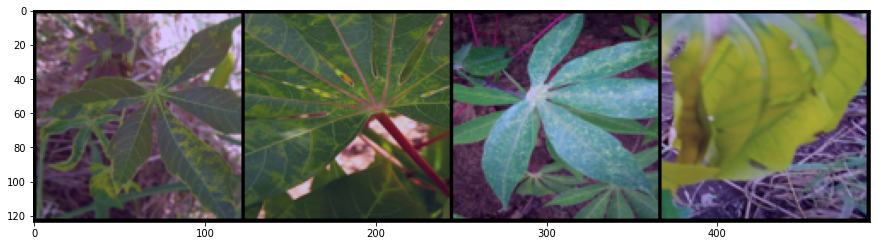

In [59]:
samples, targets = next(iter(dl))
grid = torchvision.utils.make_grid(samples[:4], normalize=True).permute(1, 2, 0).numpy()
print(dl.dataset.curr_tfms)

plt.figure(figsize=(15, 15))
plt.imshow(grid)

Compose(
    RandomResizedCropAndInterpolation(size=(120, 120), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR PIL.Image.BICUBIC)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.4298, 0.4962, 0.3130]), std=tensor([0.2142, 0.2191, 0.1954]))
)


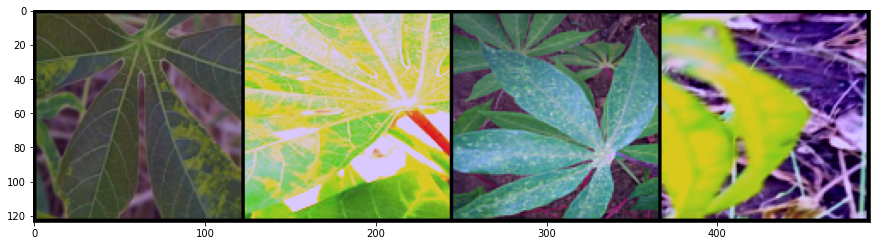

In [60]:
samples, targets = next(iter(dl))
grid = torchvision.utils.make_grid(samples[:4], normalize=True).permute(1, 2, 0).numpy()
print(dl.dataset.curr_tfms)

plt.figure(figsize=(15, 15))
plt.imshow(grid)

Compose(
    Resize(size=137, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(120, 120))
    ToTensor()
    Normalize(mean=tensor([0.4298, 0.4962, 0.3130]), std=tensor([0.2142, 0.2191, 0.1954]))
)


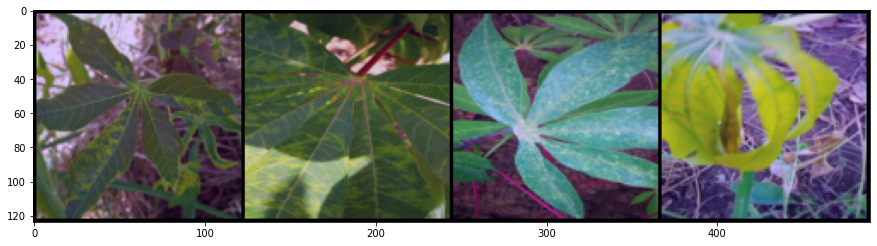

In [61]:
valid_tfm = get_valid_transformations(cfg.augmentations.valid.params)
ds = FancyImageDataset(df, cfg=cfg, transforms=valid_tfm)
dl = torch.utils.data.DataLoader(ds, batch_size=cfg.datamodule.bs)

samples, targets = next(iter(dl))
grid = torchvision.utils.make_grid(samples[:4], normalize=True).permute(1, 2, 0).numpy()

print(dl.dataset.curr_tfms)

plt.figure(figsize=(15, 15))
plt.imshow(grid)

In [62]:
# export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [63]:
# export
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

In [64]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers_schedules.ipynb.
Converted 05_lightning.data.ipynb.
Converted 05a_lightning.core.ipynb.
Converted 05b_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.
